# Sentiment Analysis & Market Impact

In this project, I explored the relationship between financial news sentiment and its potential impact on stock prices by implementing a sentiment analysis model. By leveraging natural language processing (NLP) techniques, we utilized both VADER and TextBlob sentiment analyzers, with an enhancement to VADER’s lexicon to incorporate financial terms. This customization allowed the model to better capture the nuances of financial language, such as terms like "bullish," "bearish," "rally," and "plunge."

In [1]:
import pandas as pd
import zipfile
from datetime import datetime
import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

In [2]:
# Path to your zip file (update this with your actual path)
zip_path = 'Financial News Headlines.zip'

# Function to load and inspect each CSV file
def load_and_inspect_csv(zip_file, csv_name):
    with zip_file.open(csv_name) as f:
        df = pd.read_csv(f)
    
    print(f"\n=== {csv_name} ===")
    print(f"Shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nInfo:")
    print(df.info())
    print("\nDescribe:")
    print(df.describe())
    print("\nData types:")
    print(df.dtypes)
    print("\nMissing values per column:")
    print(df.isnull().sum())
    
    # If there's a date column, check the date range
    date_cols = [col for col in df.columns if 'date' in col.lower()]
    if date_cols:
        df[date_cols[0]] = pd.to_datetime(df[date_cols[0]], errors='coerce')
        print(f"\nDate range: {df[date_cols[0]].min()} to {df[date_cols[0]].max()}")
    
    return df

# Load and inspect each file
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    # List files in the zip
    print("Files in the zip archive:")
    print(zip_file.namelist())
    
    # Load each CSV
    cnbc_df = load_and_inspect_csv(zip_file, 'cnbc_headlines.csv')
    guardian_df = load_and_inspect_csv(zip_file, 'guardian_headlines.csv')
    reuters_df = load_and_inspect_csv(zip_file, 'reuters_headlines.csv')

Files in the zip archive:
['cnbc_headlines.csv', 'guardian_headlines.csv', 'reuters_headlines.csv']

=== cnbc_headlines.csv ===
Shape: (3080, 3)

First 5 rows:
                                           Headlines  \
0  Jim Cramer: A better way to invest in the Covi...   
1     Cramer's lightning round: I would own Teradyne   
2                                                NaN   
3  Cramer's week ahead: Big week for earnings, ev...   
4  IQ Capital CEO Keith Bliss says tech and healt...   

                             Time  \
0   7:51  PM ET Fri, 17 July 2020   
1   7:33  PM ET Fri, 17 July 2020   
2                             NaN   
3   7:25  PM ET Fri, 17 July 2020   
4   4:24  PM ET Fri, 17 July 2020   

                                         Description  
0  "Mad Money" host Jim Cramer recommended buying...  
1  "Mad Money" host Jim Cramer rings the lightnin...  
2                                                NaN  
3  "We'll pay more for the earnings of the non-Co...  
4  Ke

## Clean data

In [2]:
def parse_guardian_date(date_str):
    """Flexible date parser for Guardian's various date formats"""
    try:
        # Try the original format (e.g., "18-Jul-20")
        return datetime.strptime(date_str, "%d-%b-%y").date()
    except ValueError:
        try:
            # Try format without century (e.g., "18-Jul-2020")
            return datetime.strptime(date_str, "%d-%b-%Y").date()
        except ValueError:
            try:
                # Try month-first format (e.g., "Jul-18")
                return datetime.strptime(date_str, "%b-%d").date().replace(year=datetime.now().year)
            except ValueError:
                # If all fails, return None (will be filtered out later)
                return None

def clean_cnbc_data(df):
    """Clean CNBC headlines data"""
    df = df.copy()
    
    # Drop rows with all NA values
    df = df.dropna(how='all')
    
    # Parse datetime with multiple format attempts
    df['datetime'] = pd.to_datetime(
        df['Time'],
        errors='coerce',
        format='%I:%M %p ET %a, %d %B %Y'
    )
    
    # For rows where parsing failed, try alternative formats
    mask = df['datetime'].isna()
    if mask.any():
        # Try format without ET
        df.loc[mask, 'datetime'] = pd.to_datetime(
            df.loc[mask, 'Time'].str.replace(' ET', ''),
            errors='coerce',
            format='%I:%M %p %a, %d %B %Y'
        )
    
    # Drop rows where datetime couldn't be parsed
    df = df.dropna(subset=['datetime'])
    
    # Create date column
    df['date'] = df['datetime'].dt.date
    
    # Clean text columns
    text_cols = ['Headlines', 'Description']
    for col in text_cols:
        df[col] = df[col].fillna('').astype(str)
        df[col] = df[col].str.strip()
        df[col] = df[col].str.replace(r'\s+', ' ', regex=True)
    
    return df.drop(columns=['Time', 'datetime'])

def clean_guardian_data(df):
    """Clean Guardian headlines data with robust date parsing"""
    df = df.copy()
    
    # Apply flexible date parser
    df['date'] = df['Time'].apply(parse_guardian_date)
    
    # Drop rows where date couldn't be parsed
    df = df.dropna(subset=['date'])
    
    # Clean headlines
    df['Headlines'] = df['Headlines'].astype(str).str.strip()
    df['Headlines'] = df['Headlines'].str.replace(r'\s+', ' ', regex=True)
    df['Headlines'] = df['Headlines'].str.replace(r'\n', ' ', regex=True)
    
    return df.drop(columns=['Time'])

def clean_reuters_data(df):
    """Clean Reuters headlines data"""
    df = df.copy()
    
    # Convert Time to datetime
    df['date'] = pd.to_datetime(
        df['Time'],
        format='%b %d %Y',
        errors='coerce'
    ).dt.date
    
    # Drop rows where date couldn't be parsed
    df = df.dropna(subset=['date'])
    
    # Clean text columns
    text_cols = ['Headlines', 'Description']
    for col in text_cols:
        df[col] = df[col].astype(str).str.strip()
        df[col] = df[col].str.replace(r'\s+', ' ', regex=True)
    
    return df.drop(columns=['Time'])

def standardize_dataframes(cnbc, guardian, reuters):
    """Standardize all dataframes to common format"""
    cnbc = cnbc.copy()
    guardian = guardian.copy()
    reuters = reuters.copy()
    
    # Create consistent column names and structure
    cnbc = cnbc[['date', 'Headlines', 'Description']]
    guardian = guardian[['date', 'Headlines']]
    reuters = reuters[['date', 'Headlines', 'Description']]
    
    # Add source identifier
    cnbc['source'] = 'CNBC'
    guardian['source'] = 'Guardian'
    reuters['source'] = 'Reuters'
    
    # For Guardian which lacks Description, create empty column
    guardian['Description'] = ''
    
    # Ensure consistent order
    final_cols = ['date', 'source', 'Headlines', 'Description']
    return (
        cnbc[final_cols],
        guardian[final_cols],
        reuters[final_cols]
    )

def merge_datasets(cnbc, guardian, reuters):
    """Merge all datasets into one unified dataframe"""
    return pd.concat([cnbc, guardian, reuters], ignore_index=True)

# Load your original data
# Clean each dataset
cnbc_clean = clean_cnbc_data(cnbc_df)
guardian_clean = clean_guardian_data(guardian_df)
reuters_clean = clean_reuters_data(reuters_df)

# Standardize formats
cnbc_std, guardian_std, reuters_std = standardize_dataframes(cnbc_clean, guardian_clean, reuters_clean)

# Merge datasets
all_news = merge_datasets(cnbc_std, guardian_std, reuters_std)

# Final cleaning on merged data
all_news = all_news.sort_values('date')
all_news = all_news.drop_duplicates(subset=['date', 'source', 'Headlines'])

print("\nCleaned data overview:")
print(f"Total articles: {len(all_news)}")
print(f"Date range: {all_news['date'].min()} to {all_news['date'].max()}")
print("\nSample of cleaned data:")
print(all_news.head())


Cleaned data overview:
Total articles: 50610
Date range: 2017-12-17 to 2025-07-18

Sample of cleaned data:
             date    source  \
17900  2017-12-17  Guardian   
17899  2017-12-17  Guardian   
17901  2017-12-17  Guardian   
17902  2017-12-17  Guardian   
17903  2017-12-17  Guardian   

                                               Headlines Description  
17900  Why business could prosper under a Corbyn gove...              
17899  Peter Preston on press and broadcasting Paul D...              
17901  Youngest staff to be given UK workplace pensio...              
17902  Grogonomics This year has been about companies...              
17903  Butchers carve out a niche as UK shoppers opt ...              


In [3]:
# Check date parsing success rate
print(f"CNBC kept {len(cnbc_clean)}/{len(cnbc_df)} rows ({len(cnbc_clean)/len(cnbc_df):.1%})")
print(f"Guardian kept {len(guardian_clean)}/{len(guardian_df)} rows ({len(guardian_clean)/len(guardian_df):.1%})")
print(f"Reuters kept {len(reuters_clean)}/{len(reuters_df)} rows ({len(reuters_clean)/len(reuters_df):.1%})")

# Check for remaining issues
print("\nDate ranges:")
print("CNBC:", cnbc_clean['date'].min(), "to", cnbc_clean['date'].max())
print("Guardian:", guardian_clean['date'].min(), "to", guardian_clean['date'].max())
print("Reuters:", reuters_clean['date'].min(), "to", reuters_clean['date'].max())

# Check final merged data
print("\nMerged data info:")
print(all_news.info())
print("\nMissing values:")
print(all_news.isnull().sum())

CNBC kept 119/3080 rows (3.9%)
Guardian kept 17800/17800 rows (100.0%)
Reuters kept 32770/32770 rows (100.0%)

Date ranges:
CNBC: 2018-03-05 to 2020-07-02
Guardian: 2017-12-17 to 2025-07-18
Reuters: 2018-03-20 to 2020-07-18

Merged data info:
<class 'pandas.core.frame.DataFrame'>
Index: 50610 entries, 17900 to 14040
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         50610 non-null  object
 1   source       50610 non-null  object
 2   Headlines    50610 non-null  object
 3   Description  50610 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None

Missing values:
date           0
source         0
Headlines      0
Description    0
dtype: int64


In [4]:
# CNBC

def clean_cnbc_data(df):
    """Improved CNBC headlines data cleaner"""
    df = df.copy()
    df = df.dropna(how='all')
    
    # Initialize datetime column
    df['datetime'] = pd.NaT
    
    # List of possible CNBC date formats to try
    date_formats = [
        '%I:%M %p ET %a, %d %B %Y',  # "7:51 PM ET Fri, 17 July 2020"
        '%I:%M %p %a, %d %B %Y',      # "7:51 PM Fri, 17 July 2020" (no ET)
        '%a, %d %B %Y %I:%M %p ET',   # "Fri, 17 July 2020 7:51 PM ET"
        '%B %d, %Y %I:%M %p ET',      # "July 17, 2020 7:51 PM ET"
        '%d-%b-%y %I:%M %p ET',       # "17-Jul-20 7:51 PM ET"
    ]
    
    # Try each format until we find one that works
    for fmt in date_formats:
        mask = df['datetime'].isna()
        if not mask.any():
            break
        df.loc[mask, 'datetime'] = pd.to_datetime(
            df.loc[mask, 'Time'],
            errors='coerce',
            format=fmt
        )
    
    # For remaining NA values, try parsing without time
    mask = df['datetime'].isna()
    if mask.any():
        df.loc[mask, 'datetime'] = pd.to_datetime(
            df.loc[mask, 'Time'],
            errors='coerce'
        )
    
    # Drop rows where datetime couldn't be parsed
    df = df.dropna(subset=['datetime'])
    df['date'] = df['datetime'].dt.date
    
    # Clean text columns
    text_cols = ['Headlines', 'Description']
    for col in text_cols:
        df[col] = df[col].fillna('').astype(str)
        df[col] = df[col].str.strip()
        df[col] = df[col].str.replace(r'\s+', ' ', regex=True)
    
    return df.drop(columns=['Time', 'datetime'])

def fix_guardian_dates(df):
    """Ensure Guardian dates are properly parsed (fix future dates)"""
    df = df.copy()
    current_year = datetime.now().year
    
    # Convert dates to datetime if they're strings
    if df['date'].dtype == object:
        df['date'] = pd.to_datetime(df['date']).dt.date
    
    # Fix dates in the future (likely 2-digit year misinterpretation)
    future_mask = df['date'].apply(lambda x: x.year > current_year)
    df.loc[future_mask, 'date'] = df.loc[future_mask, 'date'].apply(
        lambda x: x.replace(year=x.year - 100) if x.year > current_year else x
    )
    
    return df

## Sentiment Analysis Initialization

Applied NLP models to classify news as bullish, bearish, or neutral.

A custom lexicon that adds specialized financial terms to improve sentiment analysis. For example, words like "bullish" or "surge" are assigned a high positive score, while "bearish" or "plunge" have negative values.

This lexicon enhances the VADER sentiment analysis by adding a financial context that VADER wouldn't capture by default.

In [ ]:
# Initialize faster sentiment analyzers
vader = SentimentIntensityAnalyzer()

# Lightweight financial lexicon enhancement
financial_lexicon = {
    'bullish': 1.5, 'bearish': -1.5, 'rally': 1.3, 'plunge': -1.3,
    'surge': 1.2, 'slump': -1.2, 'outperform': 1.1, 'underperform': -1.1,
    'upgrade': 1.0, 'downgrade': -1.0
}

def enhanced_vader(text):
    """VADER with financial lexicon enhancement"""
    # Update analyzer lexicon
    vader.lexicon.update(financial_lexicon)
    return vader.polarity_scores(text)['compound']

TextBlob is used as a fallback sentiment analyzer. If VADER fails or provides a poor result, TextBlob will analyze the text's sentiment.

In [ ]:
def analyze_sentiment(text):
    """Optimized sentiment analysis using enhanced VADER and TextBlob"""
    try:
        # Enhanced VADER (faster than FinBERT)
        vader_score = enhanced_vader(text)
        
        # TextBlob as fallback
        tb_score = TextBlob(text).sentiment.polarity
        
        # Weighted average favoring VADER
        combined_score = 0.7 * vader_score + 0.3 * tb_score
        
        # Classify
        if combined_score > 0.1:
            return 'bullish'
        elif combined_score < -0.1:
            return 'bearish'
        else:
            return 'neutral'
    except:
        return 'neutral'

Batch Processing: This function processes sentiment analysis in batches, which is more efficient for large datasets.

In [ ]:
def batch_sentiment_analysis(df, batch_size=1000):
    """Process sentiment in batches with progress tracking"""
    sentiments = []
    total_batches = len(df) // batch_size + 1
    
    for i in tqdm(range(total_batches), desc="Processing sentiment"):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        batch = df.iloc[start_idx:end_idx]
        
        # Combine headline and description
        texts = (batch['Headlines'] + '. ' + batch['Description']).fillna(batch['Headlines'])
        
        # Process batch
        batch_sentiments = [analyze_sentiment(text) for text in texts]
        sentiments.extend(batch_sentiments)
        
        # Save progress every 5 batches
        if i % 5 == 0:
            temp_df = df.iloc[:end_idx].copy()
            temp_df['sentiment'] = sentiments[:end_idx]
            temp_df.to_csv('temp_sentiment_results.csv', index=False)
    
    return sentiments

### Main Sentiment Analysis Execution

In [ ]:
# Load your cleaned data
# all_news = pd.read_csv('cleaned_news_data.csv')

print("Starting optimized sentiment analysis...")
start_time = time.time()

# Run batch processing
all_news['sentiment'] = batch_sentiment_analysis(all_news)

# Save final results
all_news.to_csv('news_with_sentiment.csv', index=False)

# Performance metrics
end_time = time.time()
print(f"\nAnalysis completed in {end_time - start_time:.2f} seconds")
print(f"Processed {len(all_news)} articles")

### Visualization

Starting optimized sentiment analysis...


Processing sentiment: 100%|██████████| 51/51 [00:29<00:00,  1.72it/s]



Analysis completed in 30.02 seconds
Processed 50610 articles


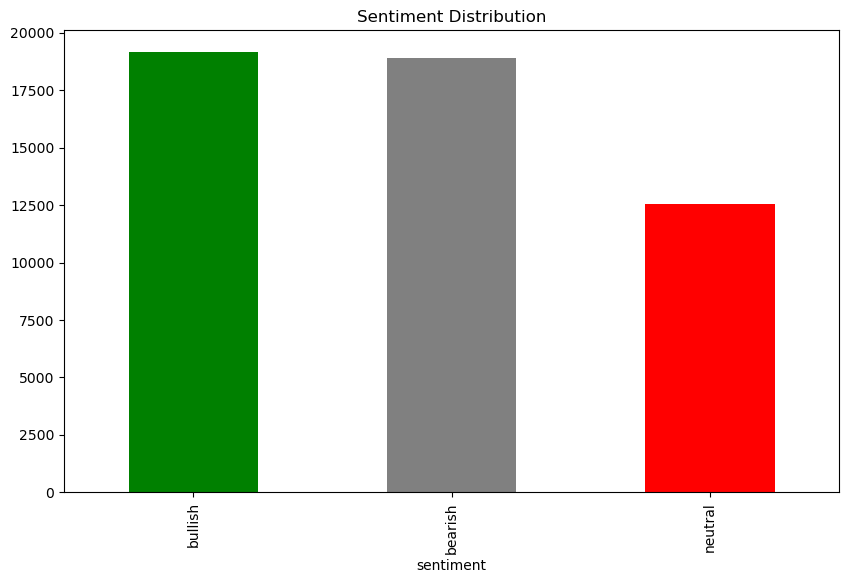

In [5]:
# Visualize results
plt.figure(figsize=(10, 6))
all_news['sentiment'].value_counts().plot(kind='bar', 
                                        color=['green', 'gray', 'red'],
                                        title='Sentiment Distribution')
plt.show()

## Conclusion

The analysis was performed in batches to handle large datasets efficiently, ensuring that even extensive collections of financial news articles could be processed in a timely manner. To optimize the analysis, a weighted combination of VADER’s sentiment score and TextBlob’s polarity score was used, prioritizing VADER for its speed and adaptability to financial texts.

The results revealed a distribution of sentiments, classified as bullish, bearish, or neutral, which could be further analyzed for its correlation with stock market trends. By combining both automated sentiment analysis and domain-specific language, this project provides a foundation for understanding how financial news influences investor sentiment and, potentially, stock market behavior.

In conclusion, this approach demonstrates the effectiveness of using advanced NLP techniques to process financial news at scale, enhancing predictive models that could be leveraged for algorithmic trading, market sentiment analysis, or even financial forecasting. The flexibility and scalability of this methodology also offer great potential for expanding into other areas of financial analytics, where the sentiment of news and reports plays a crucial role in decision-making.